In [2]:
from nltk.tokenize import RegexpTokenizer
from re import sub
from pandas import DataFrame
from pymystem3 import Mystem
import texterra
from pymorphy2 import MorphAnalyzer
from itertools import chain
from pickle import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import SpectralClustering

import scipy.sparse as sp
import matplotlib.pyplot as plt
import numpy as np

API_KEY = '9988cfb979b80264baeba1386cc7e455f99f943c'

la = np.linalg
morph = MorphAnalyzer()
m = Mystem()
# t = texterra.API(API_KEY)
alpha_tokenizer = RegexpTokenizer('[A-Za-zА-Яа-я]\w+')

In [48]:
from pandas import DataFrame, concat
from os import path
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn

In [53]:
SIZE = 10

def set_plt_params():
    title_font = {'size':'10', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 
    axis_font = {'size':'10'}
    plt.title = ('Визуализация K-Means', *title_font)
    plt.figure(figsize=(SIZE, SIZE))
    plt.xlabel('X', **axis_font)
    plt.ylabel('Y',  **axis_font)
    plt.tick_params(labelsize=10)
    seaborn.set_style("whitegrid")
    plt.grid(False)

# Домашнее задание 1 [10 баллов] 
# До 1.12.17 23:59

Задание выполняется в группе (1-4 человека). В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.

Не все части обязательны для выполнения, однако вы можете быть дополнительно оштрафованы за небрежное за выполнение одной или двух частей вместо четырех.

При возниконовении проблем с выполнением задания обращайтесь с вопросами к преподавателю. Поэтому настоятельно рекомендуется выполнять задание заранее, оставив запас времени на всевозможные технические проблемы. Если вы начали читать условие в последний вечер и не успели из-за проблем с установкой какой-либо библиотеки — это ваши проблемы.


Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание **минимума** необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* **Внятные выводы** – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Небрежное его оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в тексте в явном виде.

Сдача отчетов осуществляется через систему AnyTask.



## Кластеризация новостей

Входная коллекция данных состоит из двух частей:
1. events.csv – список 28 резонансных событий первой половины 2017 года, каждому событию присвоен свой порядковый номер (id)
2. raw_news.csv – тексты новостей из различных новостных источников, известно, к какому резонансному событию относится каждая новость (столбец event_id).

Будем считать, что одно событие – это один кластер. В этом домашнем задании вам предстоит:
1. провести кластеризацию текстов новостей и проверить, получается ли восстановить кластерную структуру 
2. проверить, можно ли использовать кластерный анализ для обобщения: найти небольшое число кластеров и проверить, получается ли выделить общие направлени новостей

In [3]:
df_events = DataFrame.from_csv('events.csv')
df_news = DataFrame.from_csv('raw_news.csv')

In [3]:
df_news.head()

,event_id,text
0,1,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...
1,1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П..."
2,1,"Аргументы и Факты (aif.ru), Москва, 14 января..."
3,1,"Google Новости ТОП, Москва, 14 января 2017 АК..."
4,1,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО..."


### Часть 1 [2 балла] Предварительная обработка текстов
Проведите предобработку новостей: токенизацию, приведение к нижнему регистру, лемматизацию. Проверьте, есть ли в коллекции дубликаты. Посчитайте, сколько новостей относится к каждому резонансному событию. 

Для начала смерджим все тексты новостей для того, чтобы получить один единый корпус, с которым можно работать:

In [6]:
texts = ' '.join(df_news.text.values)

Очистка новостей от шумов (пока реализовано только удаление УРЛОВ):

In [7]:
def remove_url(text):
    return sub(r'http\S+', '', text)

In [8]:
texts = remove_url(texts)

Токенизация (удаляем всё, что не является alphanumeric-символами):

In [9]:
tokens = alpha_tokenizer.tokenize(texts)

Лемматизация (и автоматические приведение к нижнему регистру). Мы решили рассмотреть три варианта лемматизации, поскольку не все способны одинаково хорошо справляться с контекстной омонимией (как, например, во фразе "Запотело стекло. Варенье стекло по краю банки."):

pymorphy2

In [13]:
norm_tokens = [morph.parse(word)[0].normal_form for word in tokens]

Сколько новостей относится к каждому резонансному событию?

In [11]:
df_news.event_id.value_counts()

17    102
28    100
18    100
7     100
10    100
12    100
27    100
16    100
1     100
25    100
26    100
21    100
23    100
3      84
22     82
9      82
24     62
4      62
2      51
11     49
19     45
6      41
8      27
13     24
20      8
15      7
5       2
14      2
Name: event_id, dtype: int64

Есть ли в коллекции дубликаты?

In [20]:
df_news[df_news.duplicated()]

,event_id,text
513,9,"Коммерсантъ. Новости информ. центра, Москва, ..."
518,9,"Коммерсантъ. Новости информ. центра, Москва, ..."
522,9,"Коммерсантъ. Новости информ. центра, Москва, ..."
526,9,"Коммерсантъ. Новости информ. центра, Москва, ..."
528,9,"Коммерсантъ. Новости информ. центра, Москва, ..."
536,9,"Коммерсантъ. Новости информ. центра, Москва, ..."


### Часть 2 [3 балла] Кластеризация текстов
Любым известным вам алгоритмом найдите в коллекции новостей 28 кластеров. Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте любые известные вам меры качества для оценки качества кластеризации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество кластеризации. 

Создаём матрицу совместной встречаемости

In [43]:
count_model = CountVectorizer(ngram_range=(1,1)) 
X = count_model.fit_transform(df_news.text[:100])
terms = count_model.get_feature_names()
Xc = (X.T * X)
Xc.setdiag(0)

И применяем к ней SVD-разложение:

In [30]:
U, s, Vh = la.svd(Xc.todense(), full_matrices = False)

LinAlgError: SVD did not converge

In [38]:
NUM_CLUSTERS = 2

Подаём разложенные данные на вход модели кластеризации:

In [34]:
spectral = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X)

In [35]:
spectral.labels_

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [44]:
NUM_WORDS = 3

centroid_terms = [[]]*NUM_CLUSTERS

order_centroids = spectral.cluster_centers_.argsort()[:, ::-1]

for i in range(NUM_CLUSTERS):
    centroid_terms[i] = set()
    print('Кластер {}:'.format(i))
    for j in order_centroids[i, :NUM_WORDS]:
        print(terms[j])
        centroid_terms[i].add(terms[j])
    print()

Кластер 0:
собора
на
рпц

Кластер 1:
что
на
не



In [45]:
def search_for_centroid_terms(term):
    for i, k in enumerate(centroid_terms):
        if term in k:
            return i,term

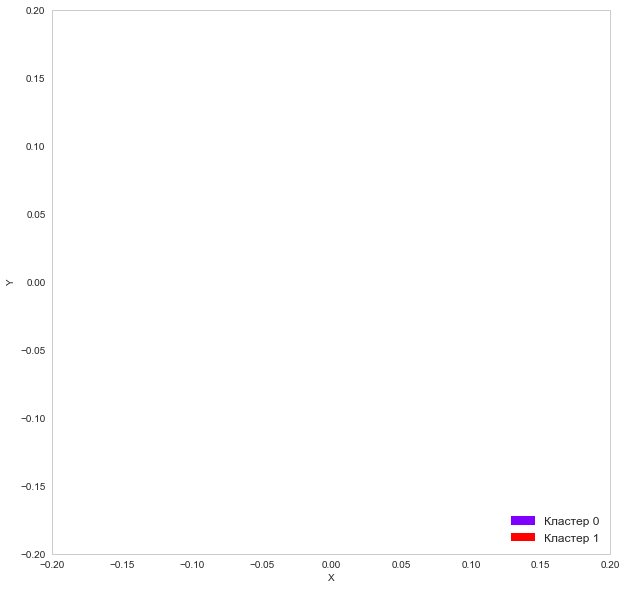

In [54]:
set_plt_params()
RANGE = 0.2

colors = cm.rainbow(np.linspace(0, 1, NUM_CLUSTERS))

reduced_X = PCA(n_components=2).fit_transform(X.todense())

for i, _ in enumerate(reduced_X):
    if search_for_centroid_terms(terms[i]):
        cluster, term = search_for_centroid_terms(terms[i])
        plt.scatter(*reduced_X[i], color=colors[cluster])
        plt.annotate('{}: {}'.format(cluster, term), (reduced_X[i]))

plt.legend([mpatches.Rectangle((0,0),1,1,fc=colors[i]) for i in range(len(colors))],
           ['Кластер {}'.format(i) for i in range(NUM_CLUSTERS)],
           loc=4,
           fontsize=12)   
plt.plot()
plt.xlim(-RANGE, RANGE)
plt.ylim(-RANGE, RANGE)
#plt.savefig('pca.png')
plt.show()

### Часть 3 [5 баллов] Кластеризация текстов (продолжение)
Задайте число кластеров заведомо меньше 28 (например, 5 кластеров). Повторно кластеризуйте новости. Можете ли вы проинтепретировать полученные кластеры? Получается ли с помощью кластерного анализа определить в каких сферах жизни (например, культура, политика, спорт) произошли события?